In [68]:
import torch 
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt

%matplotlib inline


x=torch.linspace(0,799,800)
y=torch.sin(x*2*3.1416/40)

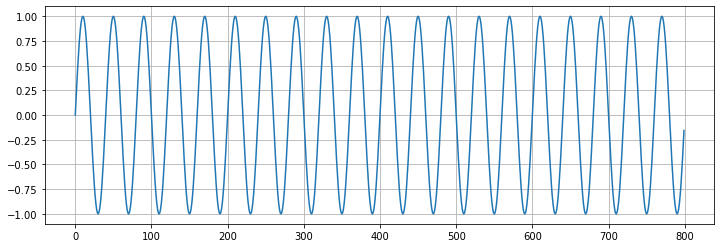

In [69]:
plt.figure(figsize=(12,4))
plt.xlim=(-10,801)
plt.grid(True)
plt.plot(y.numpy())

<class 'torch.Tensor'>


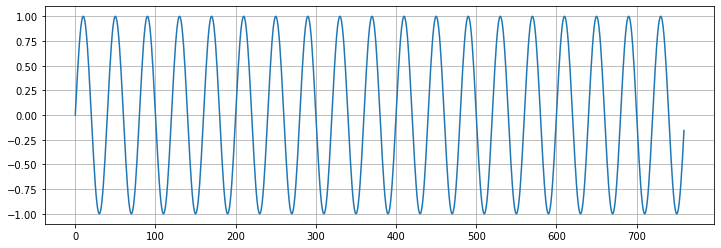

In [70]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

plt.figure(figsize=(12,4))
plt.xlim=(-10,801)
plt.grid(True)
plt.plot(train_set.numpy())


In [72]:

def input_data(seq,ws):
    out = []
    L=len(seq)

    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

window_size = 40
train_data = input_data(train_set, window_size)
train_data


[(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
           7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
           1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
           7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
          -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
          -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
          -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
          -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
  tensor([1.4480e-05])),
 (tensor([ 1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,  7.0711e-01,
           8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,  1.0000e+00,
           9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,  7.0710e-01,
           5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01, -7.2400e-06,
          -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01, -7.0711e-01

In [58]:
class LSTM(nn.Module):
    def __init__(self,input_size=1,hidden_size=50,out_size=1 ):
    
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size,hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
        
       self.hidden = (torch.zeros(1,1,hidden_size), torch.zeros(1,1,hidden_size))
   
    def forward(self, seq):
        
        lstm_out , self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        
        return pred[-1]

In [91]:
torch.manual_seed(9)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

Epoch 0 Loss: 0.042423784732818604
Performance on test range: 0.5154226422309875


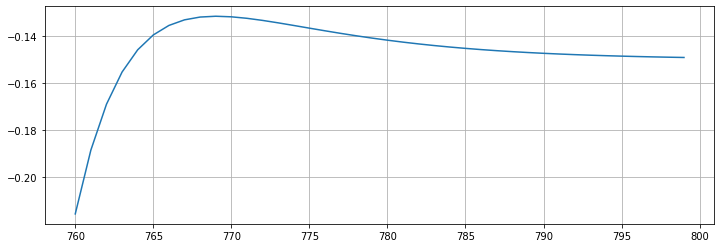

In [93]:
epochs=1
future=40

for i in range(epochs):
    for seq,y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()
        
        
    print(f"Epoch {i} Loss: {loss.item()}")
    preds = train_set[-window_size:].tolist()
    
    for f in range(future):
        
        seq = torch.FloatTensor(preds[-window_size:])
        
        with torch.no_grad():
            
            model.hidden = (torch.zeros(1,1,model.hidden_size), 
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
            
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f'Performance on test range: {loss}')
    
    plt.figure(figsize=(12,4))
    plt.xlim=(700,801)
    plt.grid(True)
    
    plt.plot(range(760,800),preds[window_size:])
   
    plt.show()